In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
grip_thinning = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/GRIP/thinning.txt', sep='\t', comment = '#')
ngrip_thinning = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/NGRIP/thinning.txt', sep='\t', comment = '#')

load_gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)

grip_accumulation = pd.DataFrame()
#take the thickness of each year first   
grip_accumulation['thick'] = load_gicc05['Depth ice/snow [m] (GRIP)'].diff() # Calculate annual layer thickness
grip_accumulation['depth']= load_gicc05['Depth ice/snow [m] (GRIP)'] # Depth in meters
grip_accumulation.dropna(inplace=True)  # Remove NaN values resulting from diff()

grip_accumulation = grip_accumulation.dropna(subset=['thick']) # Ensure no NaN values in 'thick' column


#get density 
grip_density = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/GRIP/density.txt', sep='\t', comment = '#')
grip_density

,depth,rel_dens
0,0.000000,0.352574
1,0.203704,0.356241
2,0.407407,0.359908
3,0.611111,0.363575
4,0.814815,0.367242
...,...,...
13746,2750.139179,1.000000
13747,2750.339248,1.000000
13748,2750.539318,1.000000
13749,2750.739388,1.000000


Text(0.5, 1.0, 'GRIP Accumulation Rate vs Depth')

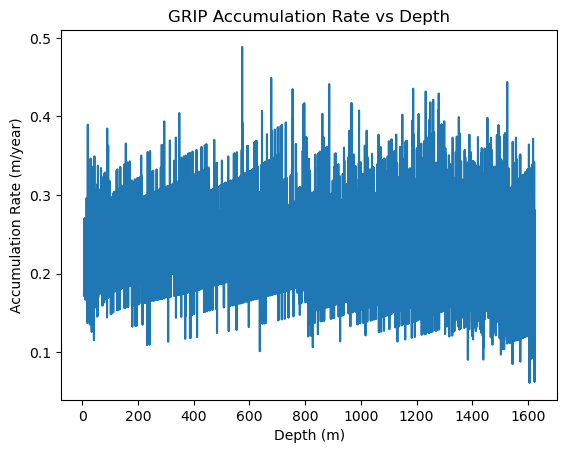

In [47]:
# acc = thickness / thinning factor
grip_accumulation['thinning'] = np.interp(grip_accumulation['depth'], grip_thinning['depth'], grip_thinning['thinning']) # Interpolate thinning factors to match depths
grip_accumulation['density'] = np.interp(grip_accumulation['depth'], grip_density['depth'], grip_density['rel_dens']) # Interpolate density to match depths

grip_accumulation['accumulation'] = (grip_accumulation['thick'] / grip_accumulation['thinning']) * grip_accumulation['density'] # Calculate accumulation rate

plt.plot(grip_accumulation['depth'], grip_accumulation['accumulation']) # Plot accumulation rate vs depth
plt.xlabel('Depth (m)')
plt.ylabel('Accumulation Rate (m/year)')
plt.title('GRIP Accumulation Rate vs Depth')

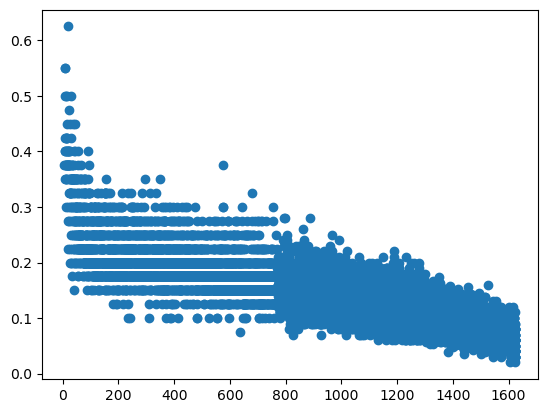

In [ ]:
plt.scatter(grip_accumulation['depth'], grip_accumulation['thick'])
plt.xlim(800,1200)

In [35]:
#this is a calculation of accumulation using NGRIP-GRIP tie points, next section is using the d18O from the gicc05 match points file

# ngrip_grip_ties = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Paleochrono BICC Work/Paleochrono BICC Experiment/BICC2025/NGRIP-GRIP/iceice_synchro_horizons.txt', sep='\t', comment = '#', skiprows=1, names=['NGRIP', 'GRIP', "unc"])
# ngrip_grip_ties = ngrip_grip_ties.where(ngrip_grip_ties['GRIP'] > grip_accumulation['depth'].max()).dropna() # Drop rows where GRIP is not greater than max depth

# ngrip_grip_ties = ngrip_grip_ties.where(ngrip_grip_ties['NGRIP'] < load_gicc05['Depth ice/snow [m] (NGRIP2)'].max()).dropna() # Drop rows where GRIP is not greater than max depth

# #get associated NGRIP ages with GICC05
# #NGRIP1 max is 1371 so this is all NGRIP2.
# gicc05 = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05_time_scale.tab', sep='\t', comment = '#', skiprows=40)

# gicc05.dropna(inplace=True, subset=['Depth ice/snow [m] (NGRIP2)', 'Age [a] (b2k)']) # Ensure no NaN values in relevant columns
# gicc05_interp = gicc05[['Age [a] (b2k)', 'Depth ice/snow [m] (NGRIP2)']]

# ngrip_grip_ties['GICC05_age'] = np.interp(ngrip_grip_ties['NGRIP'], gicc05_interp['Depth ice/snow [m] (NGRIP2)'], gicc05_interp['Age [a] (b2k)'])

# ngrip_grip_ties['time_diff'] = ngrip_grip_ties['GICC05_age'].diff().abs() # Calculate time differences between consecutive ties
# ngrip_grip_ties['depth_diff'] = ngrip_grip_ties['GRIP'].diff().abs() # Calculate depth differences between consecutive ties

# ngrip_grip_ties['annual_thickness'] = ngrip_grip_ties['depth_diff'] / ngrip_grip_ties['time_diff'] # Calculate annual layer thickness
# ngrip_grip_ties = ngrip_grip_ties.dropna(subset=['annual_thickness']) # Ensure no NaN values in 'annual_thickness' column

# grip_accumulation2 = ngrip_grip_ties[['annual_thickness']].copy(deep=True)
# grip_accumulation2['depth'] = ngrip_grip_ties['GRIP'] # Depth in meters
# grip_accumulation2['thinning'] = np.interp(grip_accumulation2['depth'], grip_thinning['depth'], grip_thinning['thinning']) # Interpolate thinning factors to match depths

# grip_accumulation2['deporate'] = grip_accumulation2['annual_thickness'] / grip_accumulation2['thinning'] # Calculate accumulation rate
# grip_accumulation_export2 = grip_accumulation2[['depth', 'deporate']]
# grip_accumulation_export2['rel_unc'] = grip_accumulation_export2['deporate'] * 0.15
# grip_accumulation_export2['comment'] = np.nan

# grip_accumulation_export2

         depth       age  mce   d18O  time_diff  depth_diff  thinning  \
19        5.50      20.2  1.0    NaN        NaN         NaN  0.999016   
21        6.05      21.6  1.0 -36.12        1.4        0.55  0.997049   
23        6.60      22.9  1.0 -34.25        1.3        0.55  1.000000   
25        7.15      24.0  1.0 -35.00        1.1        0.55  0.996463   
27        7.70      25.0  1.0 -34.69        1.0        0.55  0.999424   
...        ...       ...  ...    ...        ...         ...       ...   
9995   2748.90  103551.0  NaN -36.06       98.0        0.55  0.025067   
9997   2749.45  103648.0  NaN -35.48       97.0        0.55  0.025023   
9999   2750.00  103744.0  NaN -35.84       96.0        0.55  0.024878   
10001  2750.55  103840.0  NaN -36.37       96.0        0.55  0.024808   
10003  2751.10  103938.0  NaN -36.17       98.0        0.55  0.024808   

        density  annual_thickness  accumulation  
19     0.451587               NaN           NaN  
21     0.461489        

Text(0.5, 1.0, 'GRIP Accumulation Rate vs Age')

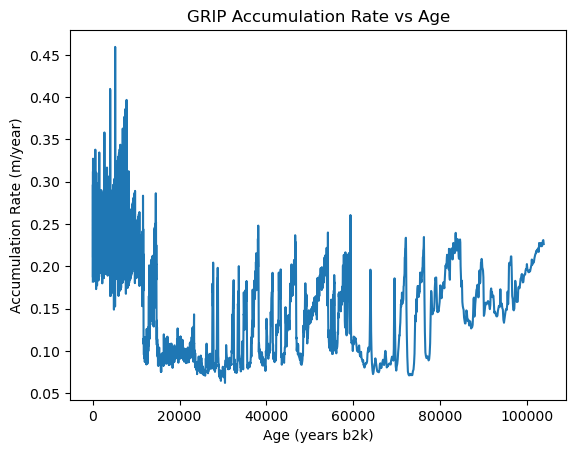

In [36]:
grip_extended_chronology = pd.read_excel('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/Chronologies/GICC05 match points and d18O and CH4.xlsx', sheet_name=4, skiprows=21, usecols=[1,2,3,4], names=['depth', 'age', 'mce', 'd18O'])

grip_extended_chronology.dropna(inplace=True, subset=['depth', 'age']) # Ensure no NaN values in relevant columns

grip_extended_chronology['time_diff'] = grip_extended_chronology['age'].diff().abs() # Calculate time differences between consecutive ties
grip_extended_chronology['depth_diff'] = grip_extended_chronology['depth'].diff().abs() # Calculate depth differences between consecutive ties

grip_extended_chronology = grip_extended_chronology.drop_duplicates(subset=['depth', 'age'])

grip_extended_chronology['thinning'] = np.interp(grip_extended_chronology['depth'], grip_thinning['depth'], grip_thinning['thinning']) # Interpolate thinning factors to match depths
grip_extended_chronology['density'] = np.interp(grip_extended_chronology['depth'], grip_density['depth'], grip_density['rel_dens']) # Interpolate density to match depths

grip_extended_chronology['annual_thickness'] = grip_extended_chronology['depth_diff'] / grip_extended_chronology['time_diff'] # Calculate annual layer thickness

grip_extended_chronology['accumulation'] = (grip_extended_chronology['annual_thickness'] / grip_extended_chronology['thinning']) * grip_extended_chronology['density'] # Calculate accumulation rate

print(grip_extended_chronology)

plt.plot(grip_extended_chronology['age'], grip_extended_chronology['accumulation']) # Plot accumulation rate vs age
plt.xlabel('Age (years b2k)')
plt.ylabel('Accumulation Rate (m/year)')
plt.title('GRIP Accumulation Rate vs Age')


In [37]:
grip_extended_chronology.rename(columns={
    'accumulation': 'deporate'
}, inplace=True)

grip_extended_chronology['rel_unc'] = grip_extended_chronology['deporate'] * 0.15  # 15% relative uncertainty

grip_extended_chronology['comment'] = np.nan

grip_extended_chronology_export = grip_extended_chronology[['depth', 'deporate', 'rel_unc', 'comment']]

grip_extended_chronology_export = grip_extended_chronology_export[1:]

grip_extended_chronology_export.to_csv('/Users/quinnmackay/Desktop/temp/thickness_deporate.txt', sep='\t', index=False)

In [38]:
# grip_accumulation.rename(columns={
#     'accumulation': 'deporate'
# }, inplace=True)

# grip_accumulation['rel_unc'] = grip_accumulation['deporate'] * 0.15  # 15% relative uncertainty

# grip_accumulation['comment'] = np.nan

# grip_accumulation_export = grip_accumulation[['depth', 'deporate', 'rel_unc', 'comment']]

# grip_accumulation_export_3 = pd.concat([grip_accumulation_export, grip_accumulation_export2], ignore_index=True)

# grip_accumulation_export_3

Linear Regression Results: Acc = 0.0218 * d18O + 0.9948


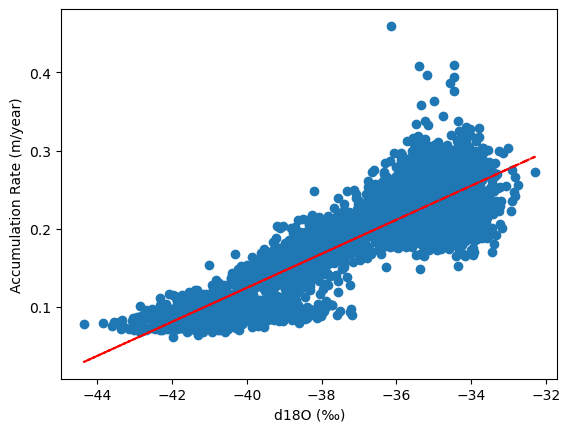

In [39]:
################################################ Isotope Calculations

from scipy.stats import linregress

grip_isotope_calc = grip_extended_chronology[['depth', 'deporate', 'd18O', 'age', 'rel_unc', 'comment']].copy(deep=True)

grip_isotope_calc = grip_isotope_calc[1:]

plt.scatter(grip_isotope_calc['d18O'], grip_isotope_calc['deporate'])
plt.ylabel('Accumulation Rate (m/year)')
plt.xlabel('d18O (‰)')

y = grip_isotope_calc['deporate']
x = grip_isotope_calc['d18O']
slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"Linear Regression Results: Acc = {slope:.4f} * d18O + {intercept:.4f}")

# Plot the regression line
plt.plot(x, intercept + slope * x, 'r', label='fitted line', linestyle='--')

Text(0.5, 1.0, 'GRIP Accumulation Rate vs Age')

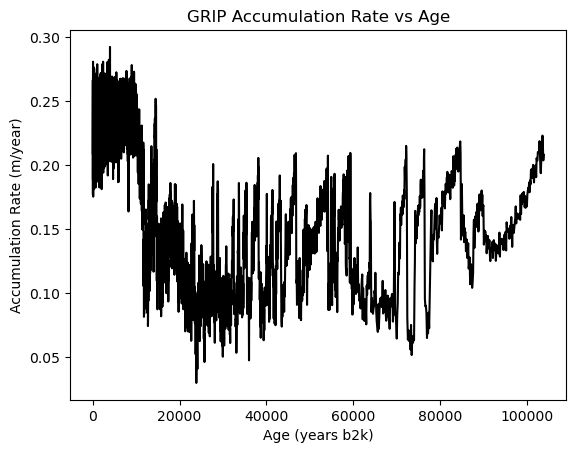

In [49]:
grip_isotope_calc['calc_acc'] = (slope * grip_isotope_calc['d18O']) + intercept
plt.plot(grip_isotope_calc['age'], grip_isotope_calc['calc_acc'], label='Calculated Accumulation Rate', color='black')
plt.xlabel('Age (years b2k)')
plt.ylabel('Accumulation Rate (m/year)')
plt.title('GRIP Accumulation Rate vs Age')

In [41]:
grip_isotope_calc_export = grip_isotope_calc[['depth', 'calc_acc', 'rel_unc', 'comment']].copy(deep=True)
grip_isotope_calc_export.rename(columns={
    'calc_acc': 'deporate'
}, inplace=True)

grip_isotope_calc_export.to_csv('/Users/quinnmackay/Desktop/temp/isotope_deporate.txt', sep='\t', index=False)